In [11]:
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, \
    convert_dict_binary_to_int, convert_dict_int_to_binary, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree
import mapomatic as mm
import mthree

from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.options import SamplerOptions, EstimatorOptions, DynamicalDecouplingOptions, TwirlingOptions

from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.qasm2 import dumps

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

CB_color_cycle_polar = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

markers = ['o', 'v', 'd', 's', '+', 'x', '^', '*', '<', '>', 'p', '1', '2', '3', '4']
linestyles = ['-', '--', ':', '-.', '-', '--', '-.', ':']
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

#calibration_sets = ["real", "avg", "recent", "decay_r"]
calibration_sets = ["real", "avg"]
# opts = ["TriQ", "SCR"]
# opts = ["TriQ"]



# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

def get_cx_lines(updated_qasm, two_qubit_gates):
    # Split the code into lines
    lines = updated_qasm.split('\n')

    re_str = r'^\s*{}'.format(two_qubit_gates)
    cx_lines = [line for line in lines if re.match(re_str, line)]
    
    # Create a dictionary to store the counts of normalized 'cx' gates
    cx_counts = {}
    
    # Iterate through the 'cx' lines, normalize, and count them
    for line in cx_lines:
        qubits = re.findall(r'q\[(\d+)\],q\[(\d+)\]', line)
        if len(qubits) == 1:
            qubit1, qubit2 = sorted(map(int, qubits[0]))
            normalized_line = f"({qubit1},{qubit2})"
            
            if normalized_line in cx_counts:
                cx_counts[normalized_line] += 1
            else:
                cx_counts[normalized_line] = 1

    return cx_counts

def get_measure_lines(updated_qasm):
    lines = updated_qasm.split('\n')
    measure_lines = [line for line in lines if re.match(r'^\s*measure', line)]
    return measure_lines

def get_initial_mapping(updated_qasm):
    initial_mappings = []
    measure_lines = get_measure_lines(updated_qasm)
    for line in measure_lines:
        qubits = re.findall(r'q\[(\d+)\] -> c\[(\d+)\]', line)
        if len(qubits) == 1:
            initial_mappings.append(int(qubits[0][0]))

    return initial_mappings

def rename_opt_type(opt_type):
    new_name = opt_type

    if opt_type == "SCR_avg":
        new_name = "SCR_s_1"
    elif opt_type == "SCR_decay_15":
        new_name = "SCR_s_3"
    elif opt_type == "SCR_decay_45":
        new_name = "SCR_s_4"
        
    elif opt_type == "TriQ_avg":
        new_name = "TriQ_s_1"
    elif opt_type == "TriQ_decay_15":
        new_name = "TriQ_s_3"
    elif opt_type == "TriQ_decay_45":
        new_name = "TriQ_s_4"
        
    return new_name



In [12]:
def get_data_scale(user_id, hw_name="ibm_brisbane"):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    
    sql = """
    SELECT d.created_datetime, circuit_name, compilation_name,
circuit_depth, total_two_qubit_gate, success_rate_tvd, success_rate_quasi, c.qubit, success_rate_polar, d.noise_level,
d.compilation_time, h.dd_enable, h.dd_sequence_type, h.dd_scheduling_method
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id
INNER JOIN framework.metric m ON d.id = m.detail_id 
INNER JOIN framework.circuit c ON d.circuit_name = c.name 
WHERE h.status = "done" and h.user_id = {} AND h.hw_name = '{}' ORDER BY qubit, circuit_name ;
    """.format(user_id, hw_name)

     # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    opt = []
    calibration_type = []
    nassc = []
    tvd = []
    header_id = []
    hellinger = []
    total_gate = []
    total_gate_cx = []
    qubit_gate_count_1q = []
    qubit_gate_count_2q = []
    circuit_depth = []
    circuit_cost = []
    execution_time = []
    success_quasi = []
    success_quasi_std = []
    success_nassc_std = []
    success_polar = []
    cx_counts = []
    initial_mappings = []
    circuit_name = []
    qubit = []
    noise_level = []
    compilation_time = []
    dd_enable = []
    dd_sequence_type = []
    dd_scheduling_method = []

    idx = 0
    for res in results:
        _header_id, _circuit_name, opt_type, _circuit_depth, _qubit_gate_count_2q, _success_tvd,  \
        _success_quasi, _qubit, _success_polar, _noise_level, _compilation_time, \
        _dd_enable, _dd_sequence_type, _dd_scheduling_method = res
            
        header_id.append(_header_id)
        circuit_name.append(_circuit_name)
        opt.append(rename_opt_type(opt_type))
        circuit_depth.append(float(_circuit_depth))
        qubit_gate_count_2q.append(float(_qubit_gate_count_2q))
        tvd.append(float(_success_tvd))
        success_quasi.append(float(_success_quasi))

        if _success_polar != None:
            success_polar.append(float(_success_polar))
        else:
            success_polar.append(float(0))
        
        qubit.append(float(_qubit))
        noise_level.append(_noise_level)
        compilation_time.append(_compilation_time)

        tmp_dd_enable = 0
        if _dd_enable == 1:
            tmp_dd_enable = 1
        
        dd_enable.append(tmp_dd_enable)
        dd_sequence_type.append(_dd_sequence_type)
        dd_scheduling_method.append(_dd_scheduling_method)

    df = pd.DataFrame({
        'header_id': header_id,
        'circuit_name': circuit_name,
        'opt': opt,
        'circuit_depth': circuit_depth,
        'qubit_gate_count_2q': qubit_gate_count_2q,
        'TVD': tvd, 
        'quasi': success_quasi, 
        'qubit': qubit,
        #'polar': success_polar,
        #'noise_level': noise_level,
        #'compilation_time': compilation_time,
        'dd_enable': dd_enable,
        'dd_seq_type': dd_sequence_type,
        'dd_sch_method': dd_scheduling_method,
        })

    return df

In [13]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0):
    
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 2

        idx_normal = i * 2
        idx_dd = (i * 2) + 1
        
        opt_data = df[(df['opt'] == opt) & (df['dd_enable'] == 0)]
        #print(opt)
        #print(opt_data)
        rects = ax.bar(x + idx_normal * width, opt_data['mean'], yerr=opt_data['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)

        opt_data_dd = df[(df['opt'] == opt) & (df['dd_enable'] == 1)]
        rects = ax.bar(x + idx_dd * width, opt_data_dd['mean'], yerr=opt_data_dd['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2, hatch=hatches[1])
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends)
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
        
    plt.ylim(ylim)
    plt.show()

## Brisbane

In [14]:
df_bris = get_data_scale(2, "ibm_brisbane")
df_bris.head()

,header_id,circuit_name,opt,circuit_depth,qubit_gate_count_2q,TVD,quasi,qubit,dd_enable,dd_seq_type,dd_sch_method
0,2024-07-05 10:16:24,bv_2,sabre_triq_avg,25.0,1.0,0.96775,0.96775,2.0,1,XpXm,alap
1,2024-07-05 10:15:57,bv_2,sabre_triq_lcd,25.0,1.0,0.97325,0.97325,2.0,0,None,None
2,2024-07-04 11:48:25,bv_2,sabre_triq_lcd,25.0,1.0,0.97050,0.97050,2.0,1,XpXm,alap
3,2024-07-03 23:54:25,bv_2,sabre_triq_lcd,25.0,1.0,0.97200,0.97200,2.0,1,XpXm,alap
4,2024-07-05 10:16:23,bv_2,qiskit_3,63.0,1.0,0.94925,0.94925,2.0,1,XpXm,alap


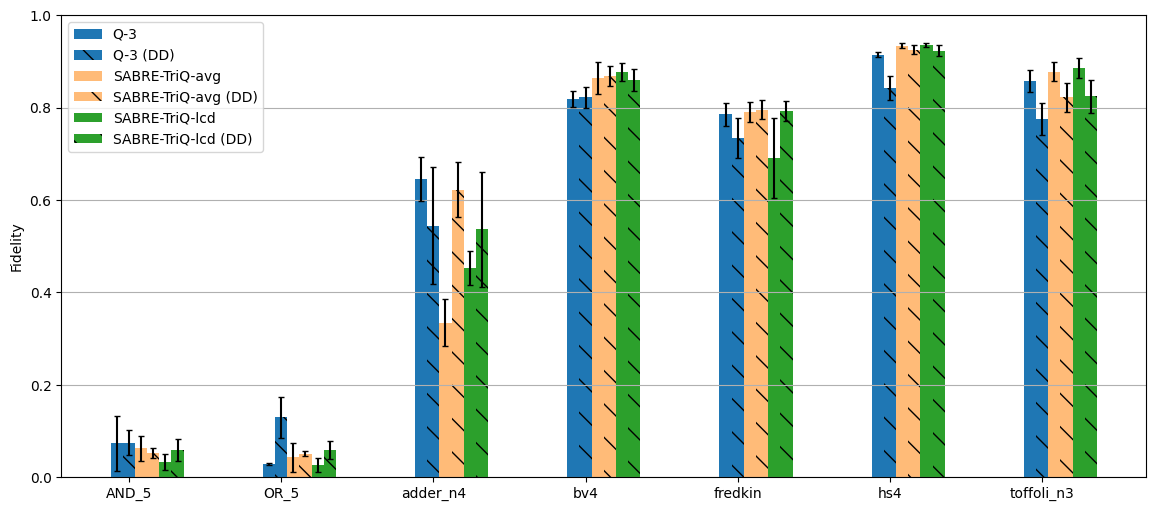

In [15]:
df_bris_cal = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'AND_5')
| (df_bris['circuit_name'] == 'bv4') | (df_bris['circuit_name'] == 'fredkin')
| (df_bris['circuit_name'] == 'hs4') | (df_bris['circuit_name'] == 'OR_5')
| (df_bris['circuit_name'] == 'toffoli_n3')
                          )]

df_bris_cal_summary = df_bris_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_cal_circuits = df_bris_cal_summary['circuit_name'].unique()
opts = df_bris_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_cal_summary, opts, legends, df_bris_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


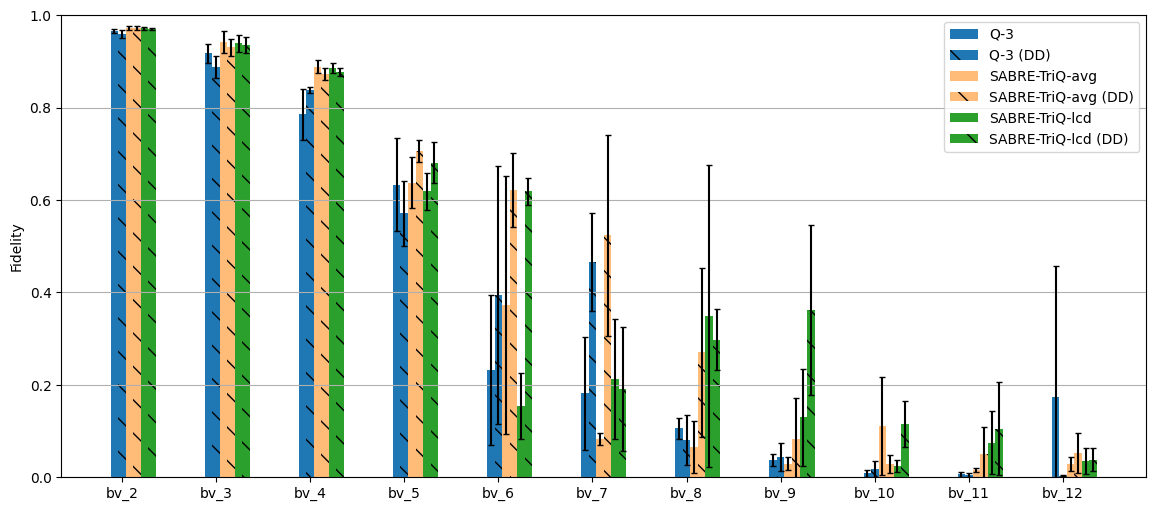

In [16]:
df_bris_bv = df_bris.loc[((df_bris['circuit_name'] == 'bv_2') | (df_bris['circuit_name'] == 'bv_3')
| (df_bris['circuit_name'] == 'bv_4') | (df_bris['circuit_name'] == 'bv_5') | (df_bris['circuit_name'] == 'bv_6')
| (df_bris['circuit_name'] == 'bv_7')| (df_bris['circuit_name'] == 'bv_8')| (df_bris['circuit_name'] == 'bv_9')
| (df_bris['circuit_name'] == 'bv_10')| (df_bris['circuit_name'] == 'bv_11')| (df_bris['circuit_name'] == 'bv_12')
                          )]

df_bris_bv_summary = df_bris_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_bv_summary = df_bris_bv_summary.sort_values(by='qubit', ascending=True)

df_bris_bv_circuits = df_bris_bv_summary['circuit_name'].unique()
opts = df_bris_bv_summary['opt'].unique()

print(df_bris_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_bv_summary, opts, legends, df_bris_bv_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


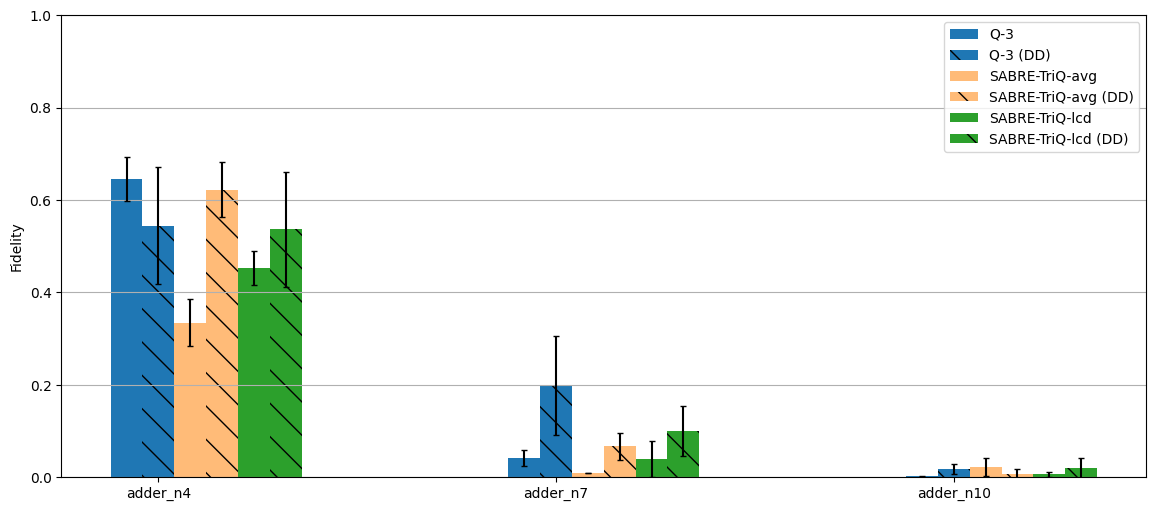

In [17]:
df_bris_add = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'adder_n7')
| (df_bris['circuit_name'] == 'adder_n10') 
                          )]

df_bris_add_summary = df_bris_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_add_summary = df_bris_add_summary.sort_values(by='qubit', ascending=True)

df_bris_add_circuits = df_bris_add_summary['circuit_name'].unique()
opts = df_bris_add_summary['opt'].unique()

print(df_bris_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_add_summary, opts, legends, df_bris_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

## Sherbrooke

In [19]:
df_sher = get_data_scale(3, "ibm_sherbrooke")
df_sher.head()

,header_id,circuit_name,opt,circuit_depth,qubit_gate_count_2q,TVD,quasi,qubit,dd_enable,dd_seq_type,dd_sch_method
0,2024-07-05 15:21:39,bv_2,sabre_triq_lcd,20.0,1.0,0.95825,0.95825,2.0,1,XY4,alap
1,2024-07-05 15:21:39,bv_2,sabre_triq_avg,20.0,1.0,0.96425,0.96425,2.0,1,XY4,alap
2,2024-07-05 15:21:14,bv_2,sabre_triq_lcd,20.0,1.0,0.96900,0.96900,2.0,0,None,None
3,2024-07-05 15:21:38,bv_2,qiskit_3,50.0,1.0,0.95475,0.95475,2.0,1,XY4,alap
4,2024-07-05 15:21:13,bv_2,sabre_triq_avg,20.0,1.0,0.97150,0.97150,2.0,0,None,None


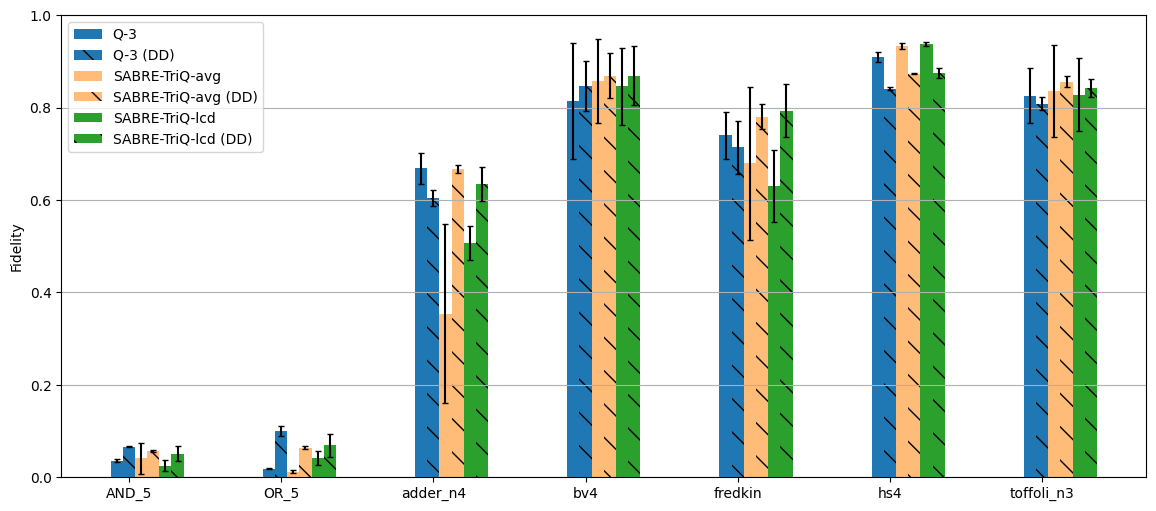

In [20]:
df_sher_cal = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'AND_5')
| (df_sher['circuit_name'] == 'bv4') | (df_sher['circuit_name'] == 'fredkin')
| (df_sher['circuit_name'] == 'hs4') | (df_sher['circuit_name'] == 'OR_5')
| (df_sher['circuit_name'] == 'toffoli_n3')
                          )]

df_sher_cal_summary = df_sher_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_cal_circuits = df_sher_cal_summary['circuit_name'].unique()
opts = df_sher_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_cal_summary, opts, legends, df_sher_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

In [21]:
df_sher_cal_summary

,circuit_name,opt,dd_enable,mean,std
0,AND_5,qiskit_3,0,0.036000,0.002828
1,AND_5,qiskit_3,1,0.065875,0.001237
2,AND_5,sabre_triq_avg,0,0.040875,0.033764
3,AND_5,sabre_triq_avg,1,0.056875,0.001591
4,AND_5,sabre_triq_lcd,0,0.025125,0.011490
5,AND_5,sabre_triq_lcd,1,0.050750,0.015910
6,OR_5,qiskit_3,0,0.018125,0.000884
7,OR_5,qiskit_3,1,0.099125,0.010783
8,OR_5,sabre_triq_avg,0,0.012125,0.003359
9,OR_5,sabre_triq_avg,1,0.063750,0.003182


['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


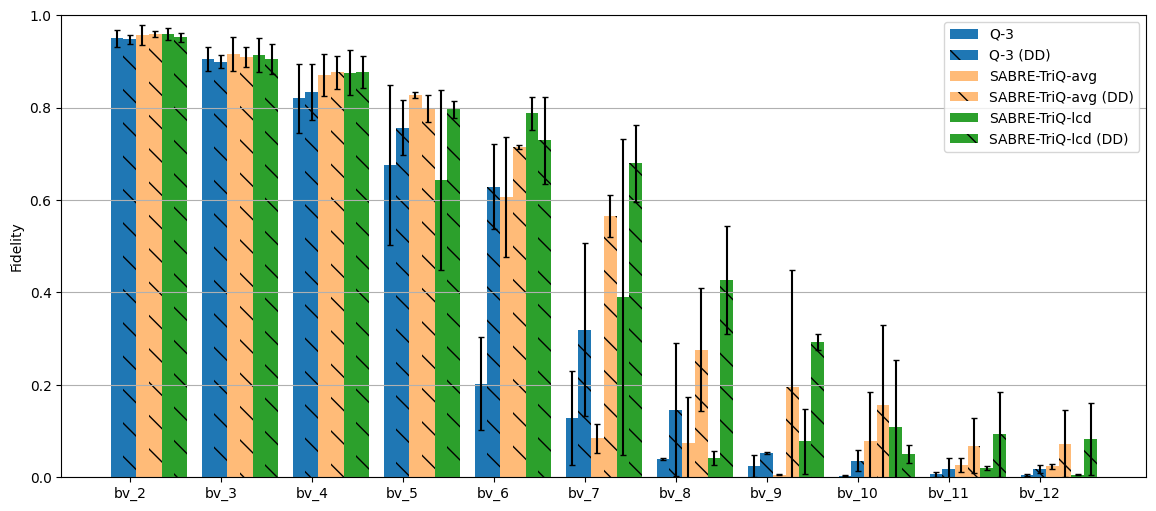

In [22]:
df_sher_bv = df_sher.loc[((df_sher['circuit_name'] == 'bv_2') | (df_sher['circuit_name'] == 'bv_3')
| (df_sher['circuit_name'] == 'bv_4') | (df_sher['circuit_name'] == 'bv_5') | (df_sher['circuit_name'] == 'bv_6')
| (df_sher['circuit_name'] == 'bv_7')| (df_sher['circuit_name'] == 'bv_8')| (df_sher['circuit_name'] == 'bv_9')
| (df_sher['circuit_name'] == 'bv_10')| (df_sher['circuit_name'] == 'bv_11')| (df_sher['circuit_name'] == 'bv_12')
                          )]

df_sher_bv_summary = df_sher_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_bv_summary = df_sher_bv_summary.sort_values(by='qubit', ascending=True)

df_sher_bv_circuits = df_sher_bv_summary['circuit_name'].unique()
opts = df_sher_bv_summary['opt'].unique()

print(df_sher_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_bv_summary, opts, legends, df_sher_bv_circuits, [0,1], "Fidelity", width=0.14, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


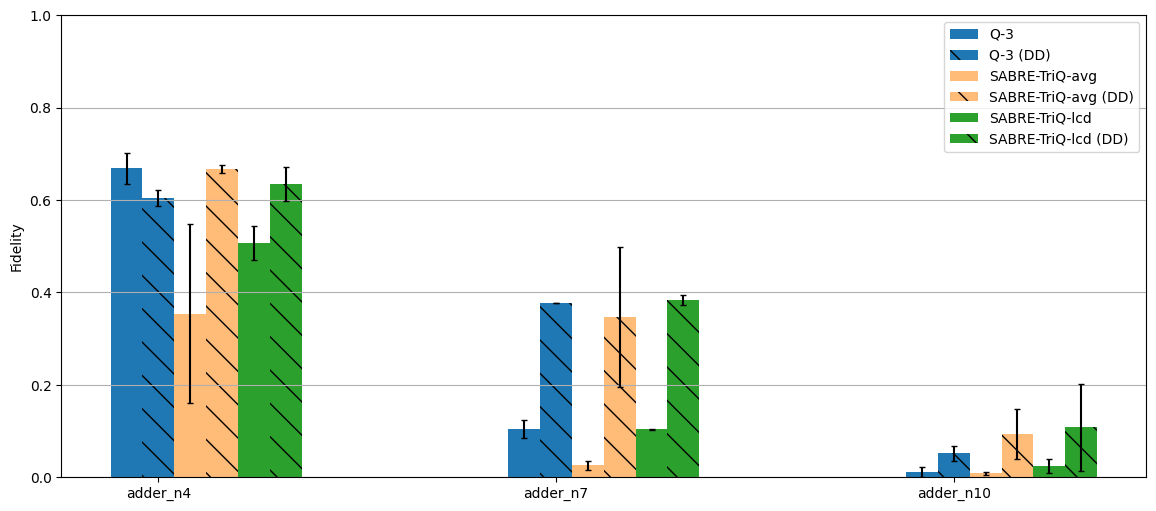

In [23]:
df_sher_add = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'adder_n7')
| (df_sher['circuit_name'] == 'adder_n10') 
                          )]

df_sher_add_summary = df_sher_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_add_summary = df_sher_add_summary.sort_values(by='qubit', ascending=True)

df_sher_add_circuits = df_sher_add_summary['circuit_name'].unique()
opts = df_sher_add_summary['opt'].unique()

print(df_sher_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_add_summary, opts, legends, df_sher_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

adder 7 original


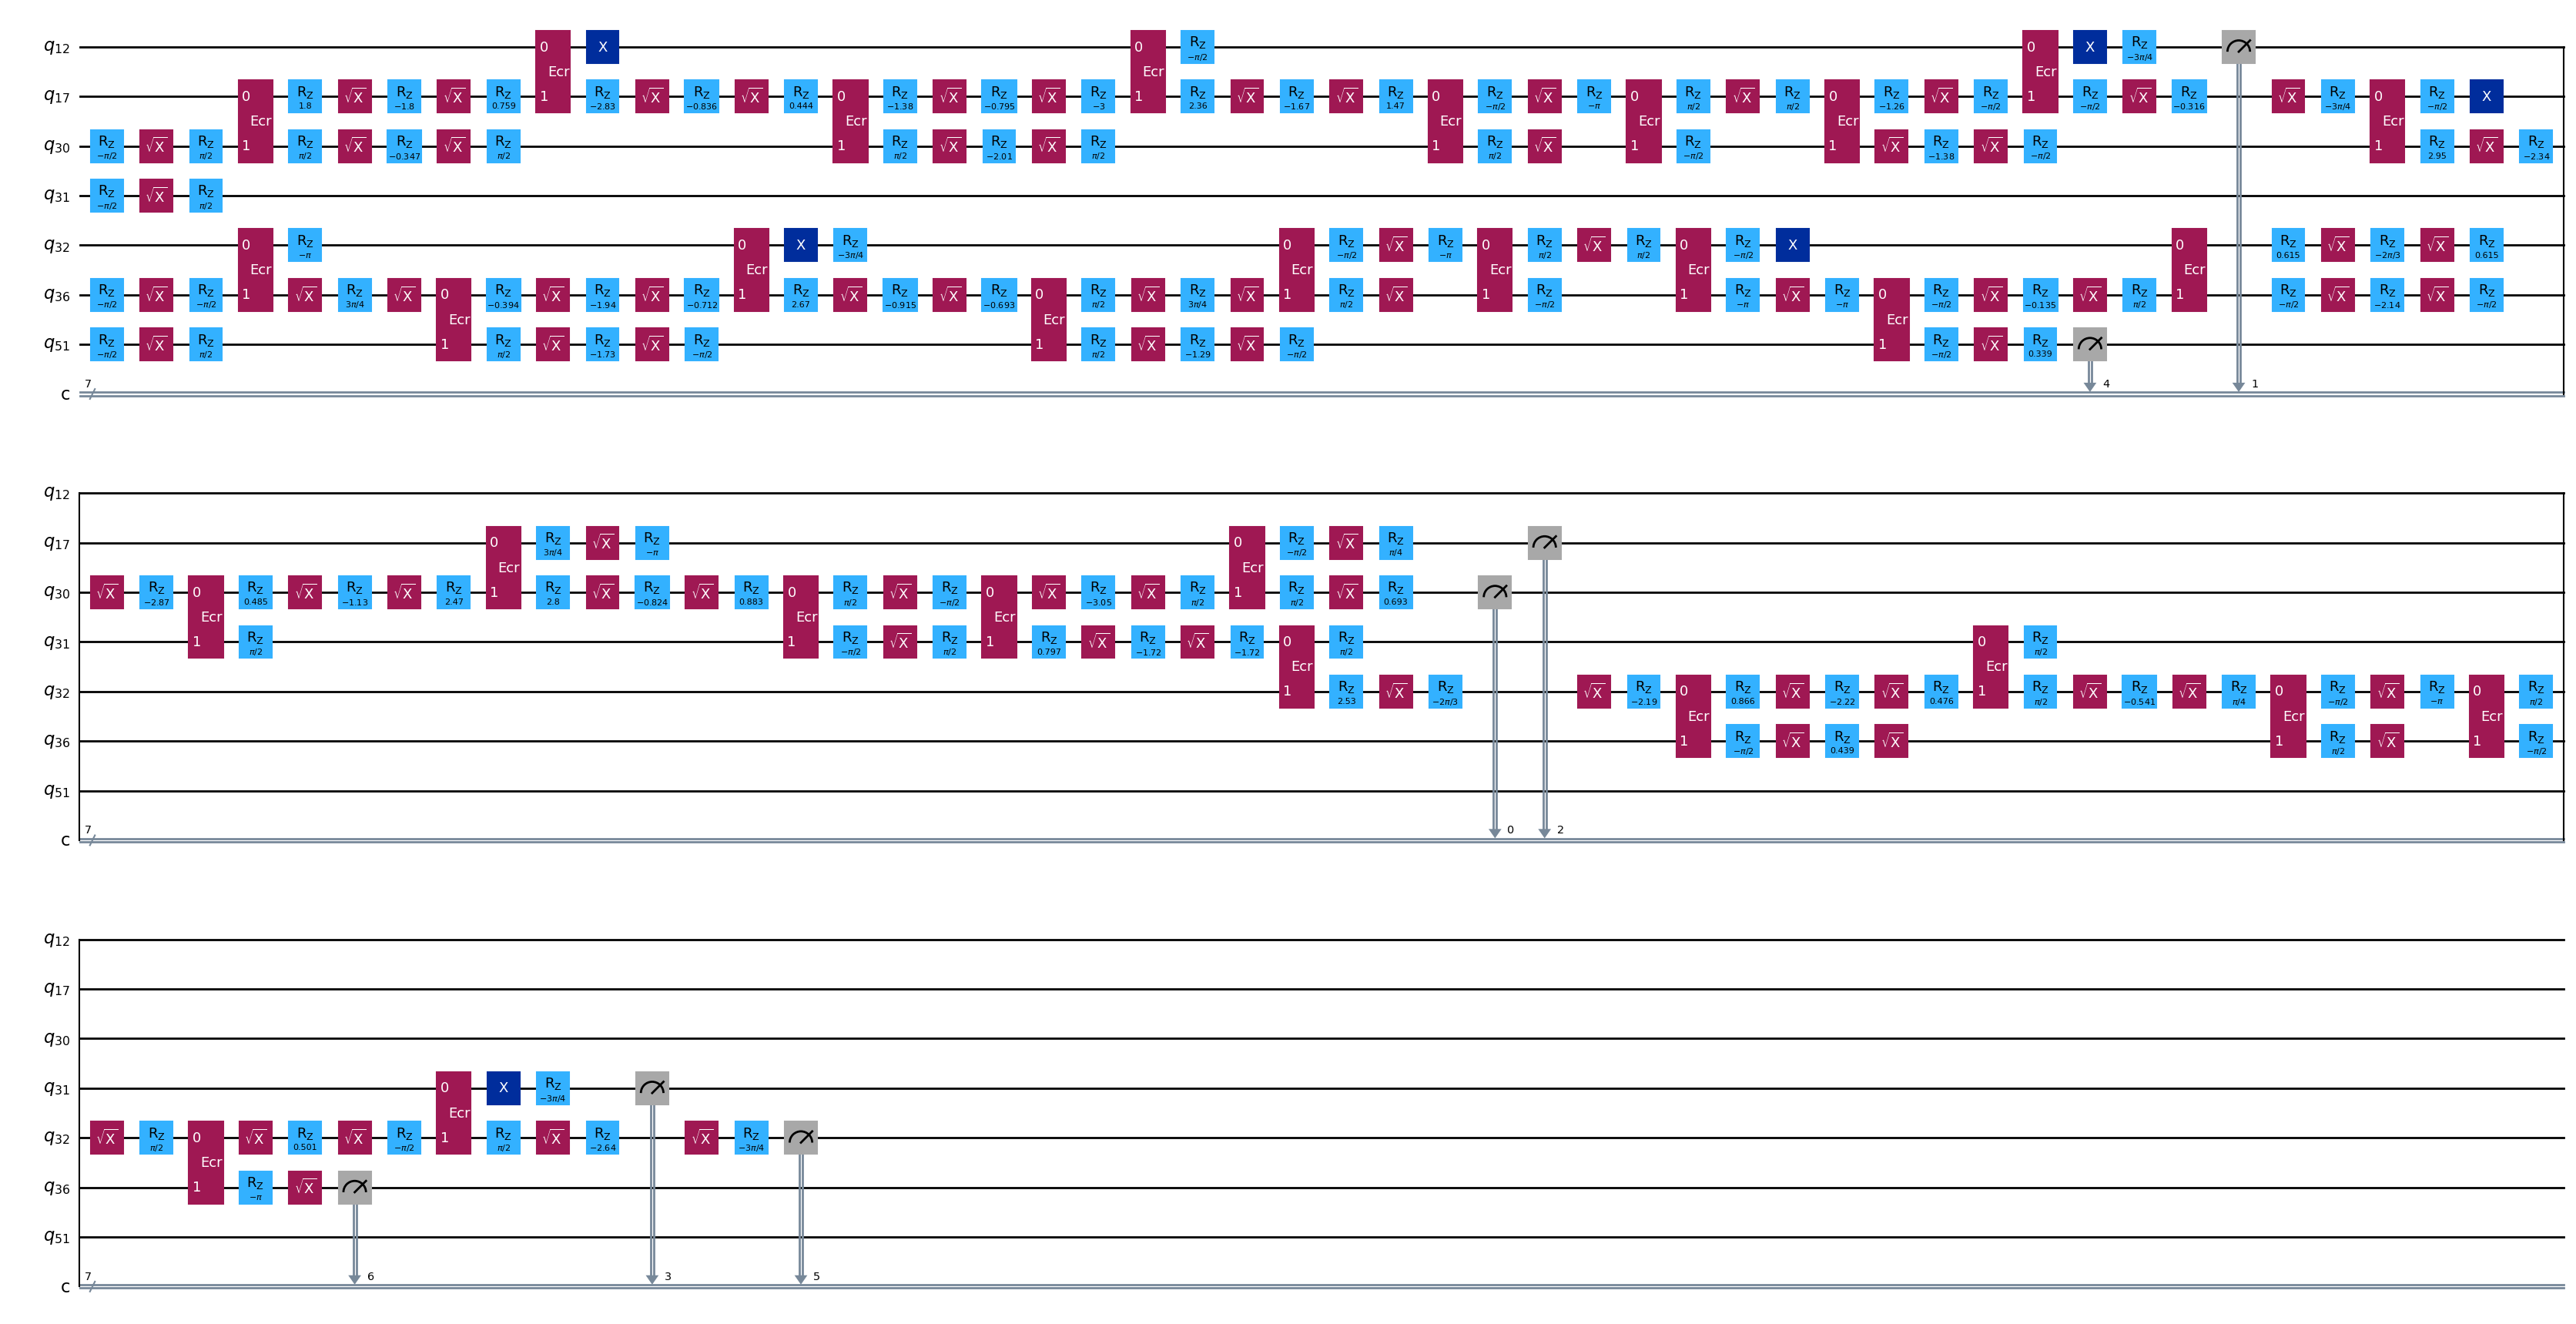

In [28]:
adder_n7_qasm = """
OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
qreg q[127];
creg c[7];
rz(-pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
rz(1.8041430550073736) q[17];
sx q[17];
rz(-1.798037194550199) q[17];
sx q[17];
rz(0.7586506328537679) q[17];
ecr q[12],q[17];
x q[12];
rz(-2.8331525235845607) q[17];
sx q[17];
rz(-0.8362414065403492) q[17];
sx q[17];
rz(0.44373606914313957) q[17];
rz(pi/2) q[30];
sx q[30];
rz(-0.3466843859885991) q[30];
sx q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
rz(-1.375660885397902) q[17];
sx q[17];
rz(-0.7949780713745476) q[17];
sx q[17];
rz(-3.0040518232508164) q[17];
ecr q[12],q[17];
rz(-pi/2) q[12];
rz(2.3610305519942063) q[17];
sx q[17];
rz(-1.6688272754951292) q[17];
sx q[17];
rz(1.472290910648372) q[17];
rz(pi/2) q[30];
sx q[30];
rz(-2.0095101042037458) q[30];
sx q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
rz(-pi/2) q[17];
sx q[17];
rz(-pi) q[17];
rz(pi/2) q[30];
sx q[30];
ecr q[17],q[30];
rz(pi/2) q[17];
sx q[17];
rz(pi/2) q[17];
rz(-pi/2) q[30];
ecr q[17],q[30];
rz(-1.2550933731991074) q[17];
sx q[17];
rz(-pi/2) q[17];
ecr q[12],q[17];
x q[12];
rz(-3*pi/4) q[12];
rz(-pi/2) q[17];
sx q[17];
rz(-0.3157029535957889) q[17];
sx q[17];
rz(-3*pi/4) q[17];
sx q[30];
rz(-1.3780997892956606) q[30];
sx q[30];
rz(-pi/2) q[30];
ecr q[17],q[30];
rz(-pi/2) q[17];
x q[17];
rz(2.9523773730265903) q[30];
sx q[30];
rz(-2.337853061542906) q[30];
sx q[30];
rz(-2.8723546818529133) q[30];
rz(-pi/2) q[31];
sx q[31];
rz(pi/2) q[31];
ecr q[30],q[31];
rz(0.4852227601401231) q[30];
sx q[30];
rz(-1.1343837173114544) q[30];
sx q[30];
rz(2.4658381240653853) q[30];
ecr q[17],q[30];
rz(3*pi/4) q[17];
sx q[17];
rz(-pi) q[17];
rz(2.7999553786863416) q[30];
sx q[30];
rz(-0.8240735527679615) q[30];
sx q[30];
rz(0.8825745384316992) q[30];
rz(pi/2) q[31];
ecr q[30],q[31];
rz(pi/2) q[30];
sx q[30];
rz(-pi/2) q[30];
rz(-pi/2) q[31];
sx q[31];
rz(pi/2) q[31];
ecr q[30],q[31];
sx q[30];
rz(-3.049539246706475) q[30];
sx q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
rz(-pi/2) q[17];
sx q[17];
rz(pi/4) q[17];
rz(pi/2) q[30];
sx q[30];
rz(0.6933447565141293) q[30];
rz(0.7965538042351419) q[31];
sx q[31];
rz(-1.7190636423125092) q[31];
sx q[31];
rz(-1.720720764319946) q[31];
rz(-pi/2) q[36];
sx q[36];
rz(-pi/2) q[36];
ecr q[32],q[36];
rz(-pi) q[32];
sx q[36];
rz(3*pi/4) q[36];
sx q[36];
rz(-pi/2) q[51];
sx q[51];
rz(pi/2) q[51];
ecr q[36],q[51];
rz(-0.3936598011228707) q[36];
sx q[36];
rz(-1.9370599079871518) q[36];
sx q[36];
rz(-0.7115668532787325) q[36];
ecr q[32],q[36];
x q[32];
rz(-3*pi/4) q[32];
rz(2.672781349547492) q[36];
sx q[36];
rz(-0.9151046771304792) q[36];
sx q[36];
rz(-0.6931698133840136) q[36];
rz(pi/2) q[51];
sx q[51];
rz(-1.732431279561439) q[51];
sx q[51];
rz(-pi/2) q[51];
ecr q[36],q[51];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/4) q[36];
sx q[36];
ecr q[32],q[36];
rz(-pi/2) q[32];
sx q[32];
rz(-pi) q[32];
rz(pi/2) q[36];
sx q[36];
ecr q[32],q[36];
rz(pi/2) q[32];
sx q[32];
rz(pi/2) q[32];
rz(-pi/2) q[36];
ecr q[32],q[36];
rz(-pi/2) q[32];
x q[32];
rz(-pi) q[36];
sx q[36];
rz(-pi) q[36];
rz(pi/2) q[51];
sx q[51];
rz(-1.2856981968276813) q[51];
sx q[51];
rz(-pi/2) q[51];
ecr q[36],q[51];
rz(-pi/2) q[36];
sx q[36];
rz(-0.13456116470396928) q[36];
sx q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
rz(0.6154797086703869) q[32];
sx q[32];
rz(-2*pi/3) q[32];
sx q[32];
rz(0.6154797086703874) q[32];
ecr q[31],q[32];
rz(pi/2) q[31];
rz(2.5261129449194053) q[32];
sx q[32];
rz(-2*pi/3) q[32];
sx q[32];
rz(-2.1862760354652844) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(-2.144071268907716) q[36];
sx q[36];
rz(-pi/2) q[36];
ecr q[32],q[36];
rz(0.8664306393005026) q[32];
sx q[32];
rz(-2.221947509473794) q[32];
sx q[32];
rz(0.47561741207987174) q[32];
ecr q[31],q[32];
rz(pi/2) q[31];
rz(pi/2) q[32];
sx q[32];
rz(-0.5410695548384403) q[32];
sx q[32];
rz(pi/4) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(0.43871377740884965) q[36];
sx q[36];
ecr q[32],q[36];
rz(-pi/2) q[32];
sx q[32];
rz(-pi) q[32];
rz(pi/2) q[36];
sx q[36];
ecr q[32],q[36];
rz(pi/2) q[32];
sx q[32];
rz(pi/2) q[32];
rz(-pi/2) q[36];
ecr q[32],q[36];
sx q[32];
rz(0.5012421940217897) q[32];
sx q[32];
rz(-pi/2) q[32];
ecr q[31],q[32];
x q[31];
rz(-3*pi/4) q[31];
rz(pi/2) q[32];
sx q[32];
rz(-2.640350459568004) q[32];
sx q[32];
rz(-3*pi/4) q[32];
rz(-pi) q[36];
sx q[36];
rz(-pi/2) q[51];
sx q[51];
rz(0.3386650806636897) q[51];
measure q[30] -> c[0];
measure q[12] -> c[1];
measure q[17] -> c[2];
measure q[31] -> c[3];
measure q[51] -> c[4];
measure q[32] -> c[5];
measure q[36] -> c[6];
"""

print("adder 7 original")
adder_n7 = QuantumCircuit.from_qasm_str(adder_n7_qasm)
adder_n7.draw("mpl", idle_wires=False, fold=50)

adder_n7 - qiskit 3 - with DD XY4 alap


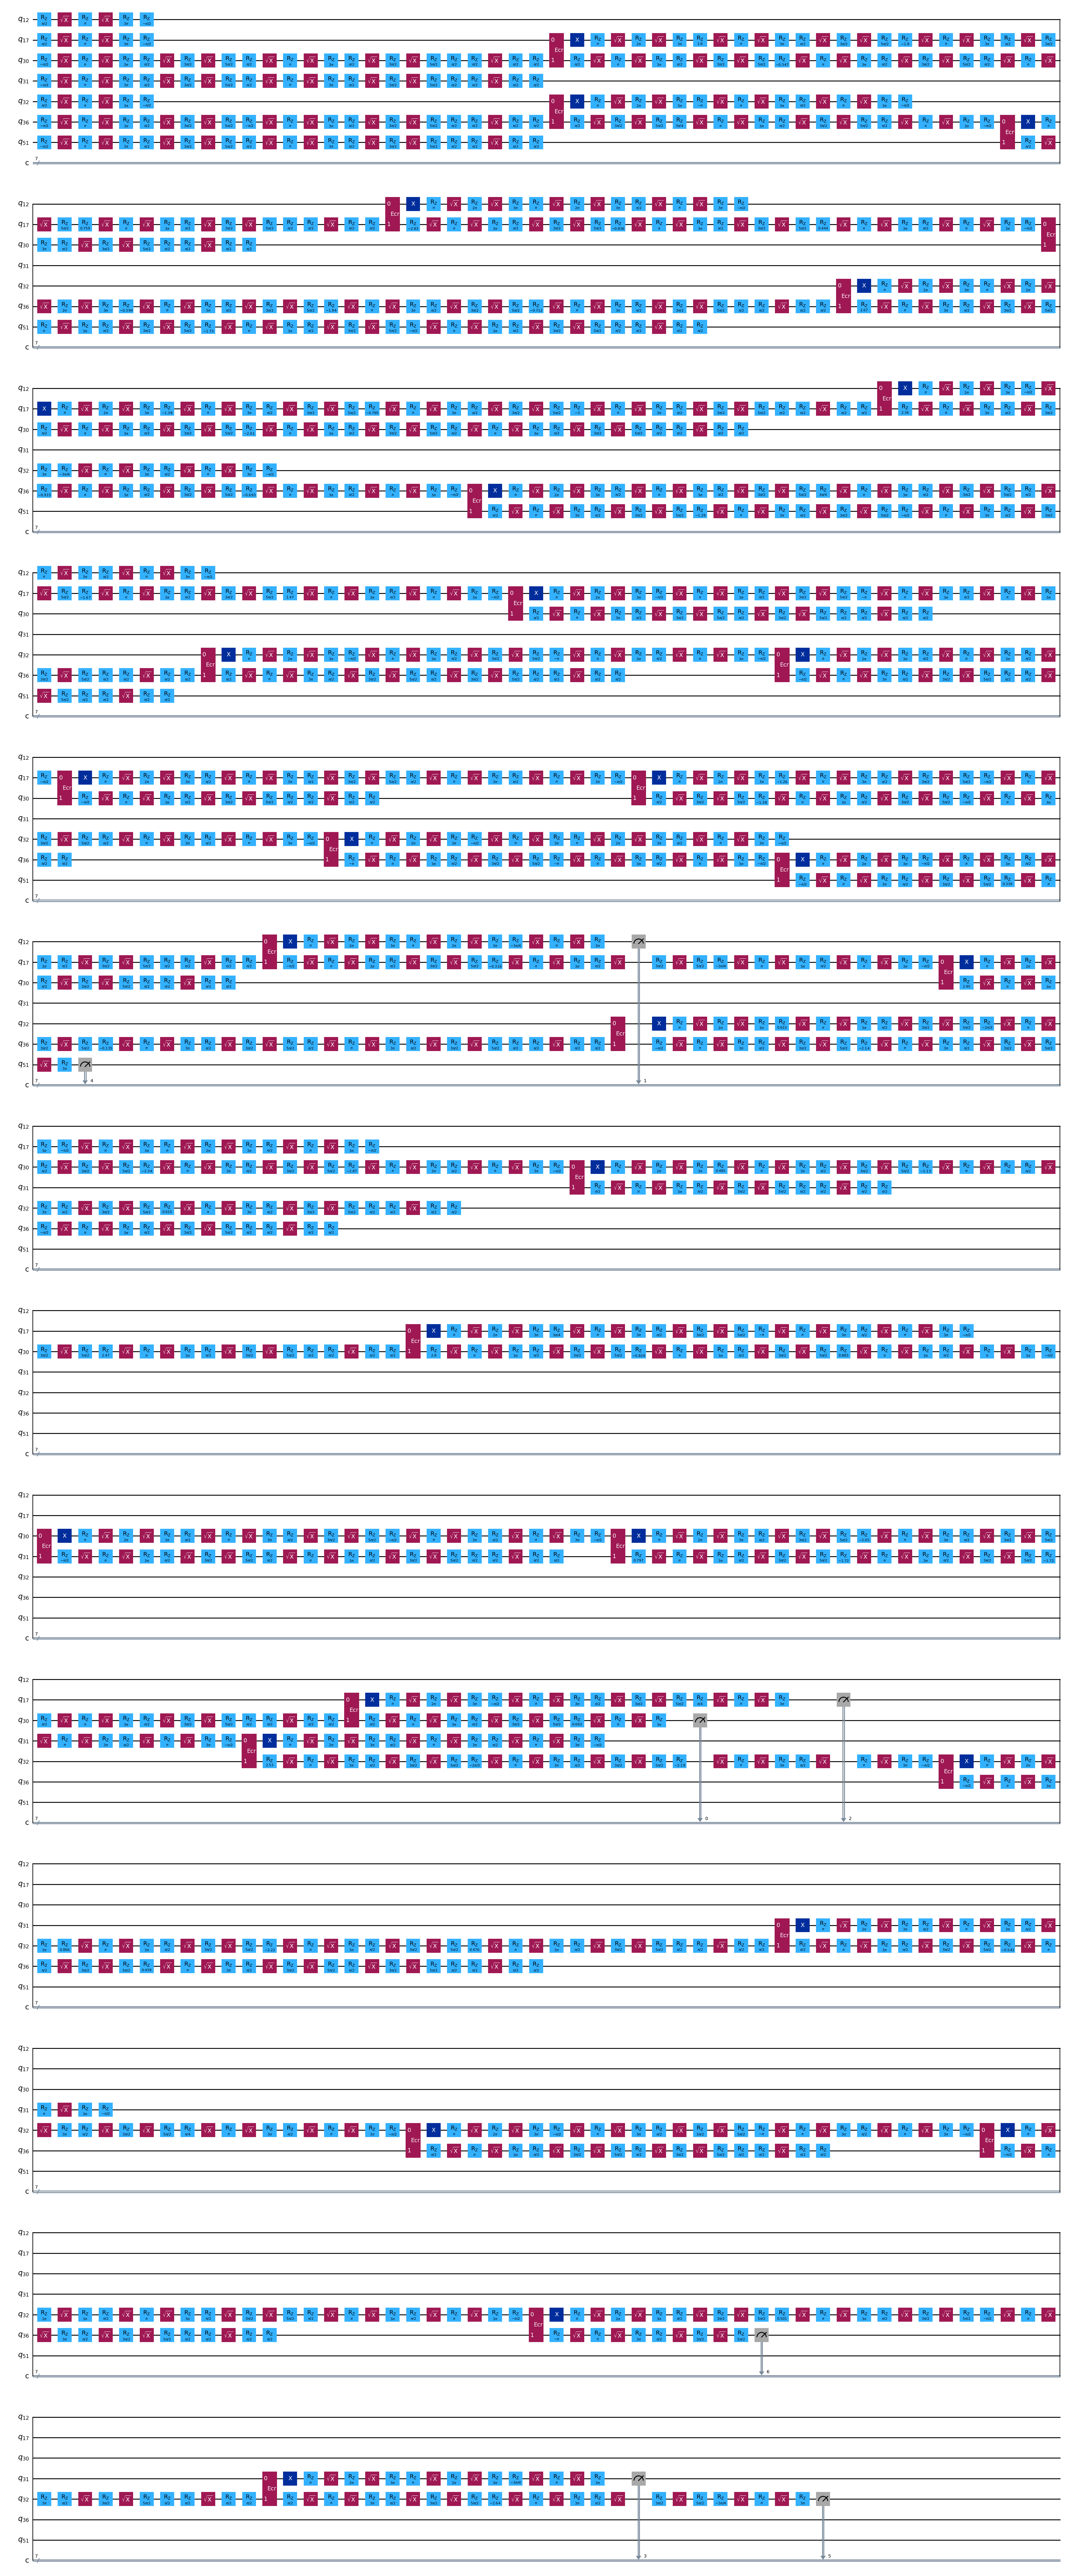

In [30]:
adder_n7_qasm = """
OPENQASM 2.0;
include "qelib1.inc";
gate rzx(param0) q0,q1 { h q1; cx q0,q1; rz(param0) q1; cx q0,q1; h q1; }
gate ecr q0,q1 { rzx(pi/4) q0,q1; x q0; rzx(-pi/4) q0,q1; }
qreg q[127];
creg c[7];
rz(pi/2) q[12];
sx q[12];
rz(pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-pi/2) q[12];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(-pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(1.8041430550073736) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-1.798037194550199) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(0.7586506328537679) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
ecr q[12],q[17];
x q[12];
rz(pi) q[12];
sx q[12];
rz(2*pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(pi) q[12];
sx q[12];
rz(2*pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(pi/2) q[12];
sx q[12];
rz(pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-pi/2) q[12];
rz(-2.8331525235845607) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-0.8362414065403492) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(0.44373606914313957) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-0.3466843859885991) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-1.375660885397902) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-0.7949780713745476) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-3.0040518232508164) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
ecr q[12],q[17];
x q[12];
rz(pi) q[12];
sx q[12];
rz(2*pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-pi/2) q[12];
sx q[12];
rz(pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(pi/2) q[12];
sx q[12];
rz(pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-pi/2) q[12];
rz(2.3610305519942063) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-1.6688272754951292) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(1.472290910648372) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-2.0095101042037458) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-pi) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(-pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-1.2550933731991074) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi/2) q[17];
rz(pi/2) q[17];
ecr q[12],q[17];
x q[12];
rz(pi) q[12];
sx q[12];
rz(2*pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(pi) q[12];
sx q[12];
rz(2*pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-3*pi/4) q[12];
sx q[12];
rz(pi) q[12];
sx q[12];
rz(3*pi) q[12];
rz(-pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-0.3157029535957889) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-3*pi/4) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-1.3780997892956606) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(2.9523773730265903) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-2.337853061542906) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-2.8723546818529133) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(-pi/2) q[30];
rz(-pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
ecr q[30],q[31];
x q[30];
rz(pi) q[30];
sx q[30];
rz(2*pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(0.4852227601401231) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-1.1343837173114544) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(2.4658381240653853) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(3*pi/4) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(-pi) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
rz(2.7999553786863416) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-0.8240735527679615) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(0.8825745384316992) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(-pi/2) q[30];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
ecr q[30],q[31];
x q[30];
rz(pi) q[30];
sx q[30];
rz(2*pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(-pi/2) q[30];
rz(-pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi/2) q[31];
rz(pi/2) q[31];
ecr q[30],q[31];
x q[30];
rz(pi) q[30];
sx q[30];
rz(2*pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(-3.049539246706475) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
sx q[30];
rz(pi/2) q[30];
rz(pi/2) q[30];
ecr q[17],q[30];
x q[17];
rz(pi) q[17];
sx q[17];
rz(2*pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(-pi/2) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[17];
sx q[17];
rz(3*pi/2) q[17];
sx q[17];
rz(5*pi/2) q[17];
rz(pi/4) q[17];
sx q[17];
rz(pi) q[17];
sx q[17];
rz(3*pi) q[17];
rz(pi/2) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(pi/2) q[30];
sx q[30];
rz(3*pi/2) q[30];
sx q[30];
rz(5*pi/2) q[30];
rz(0.6933447565141293) q[30];
sx q[30];
rz(pi) q[30];
sx q[30];
rz(3*pi) q[30];
rz(0.7965538042351419) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(-1.7190636423125092) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(3*pi/2) q[31];
sx q[31];
rz(5*pi/2) q[31];
rz(-1.720720764319946) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(-pi/2) q[31];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(3*pi/4) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(-pi/2) q[36];
rz(-pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
sx q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
ecr q[36],q[51];
x q[36];
rz(pi) q[36];
sx q[36];
rz(2*pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(-0.3936598011228707) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-1.9370599079871518) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-0.7115668532787325) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-3*pi/4) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(2.672781349547492) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-0.9151046771304792) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-0.6931698133840136) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(-pi/2) q[36];
rz(pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(-1.732431279561439) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(-pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
sx q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
ecr q[36],q[51];
x q[36];
rz(pi) q[36];
sx q[36];
rz(2*pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(3*pi/4) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-pi) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-pi) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(-pi/2) q[36];
rz(pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(-1.2856981968276813) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(-pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
sx q[51];
rz(pi/2) q[51];
rz(pi/2) q[51];
ecr q[36],q[51];
x q[36];
rz(pi) q[36];
sx q[36];
rz(2*pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-0.13456116470396928) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(0.6154797086703869) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-2*pi/3) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(0.6154797086703874) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
ecr q[31],q[32];
x q[31];
rz(pi) q[31];
sx q[31];
rz(2*pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(-pi/2) q[31];
rz(2.5261129449194053) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-2*pi/3) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-2.1862760354652844) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-2.144071268907716) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(0.8664306393005026) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-2.221947509473794) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(0.47561741207987174) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
ecr q[31],q[32];
x q[31];
rz(pi) q[31];
sx q[31];
rz(2*pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(-pi/2) q[31];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-0.5410695548384403) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/4) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(0.43871377740884965) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-pi) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi/2) q[32];
rz(-pi/2) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
sx q[36];
rz(pi/2) q[36];
rz(pi/2) q[36];
ecr q[32],q[36];
x q[32];
rz(pi) q[32];
sx q[32];
rz(2*pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(0.5012421940217897) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
sx q[32];
rz(pi/2) q[32];
rz(pi/2) q[32];
ecr q[31],q[32];
x q[31];
rz(pi) q[31];
sx q[31];
rz(2*pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi) q[31];
sx q[31];
rz(2*pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(-3*pi/4) q[31];
sx q[31];
rz(pi) q[31];
sx q[31];
rz(3*pi) q[31];
rz(pi/2) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-2.640350459568004) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(pi/2) q[32];
sx q[32];
rz(3*pi/2) q[32];
sx q[32];
rz(5*pi/2) q[32];
rz(-3*pi/4) q[32];
sx q[32];
rz(pi) q[32];
sx q[32];
rz(3*pi) q[32];
rz(-pi) q[36];
sx q[36];
rz(pi) q[36];
sx q[36];
rz(3*pi) q[36];
rz(pi/2) q[36];
sx q[36];
rz(3*pi/2) q[36];
sx q[36];
rz(5*pi/2) q[36];
rz(-pi/2) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
rz(pi/2) q[51];
sx q[51];
rz(3*pi/2) q[51];
sx q[51];
rz(5*pi/2) q[51];
rz(0.3386650806636897) q[51];
sx q[51];
rz(pi) q[51];
sx q[51];
rz(3*pi) q[51];
measure q[30] -> c[0];
measure q[12] -> c[1];
measure q[17] -> c[2];
measure q[31] -> c[3];
measure q[51] -> c[4];
measure q[32] -> c[5];
measure q[36] -> c[6];
"""

print("adder_n7 - qiskit 3 - with DD XY4 alap")
adder_n7 = QuantumCircuit.from_qasm_str(adder_n7_qasm)
adder_n7.draw("mpl", idle_wires=False, fold=50)

In [ ]:
adder_n7_qasm = """

"""

adder_n7 = QuantumCircuit.from_qasm_str(adder_n7_qasm)
adder_n7.draw("mpl", idle_wires=False, fold=50)